In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import re

In [ ]:
path_img = Path("dataset_classification")
bs = 32
tfms = get_transforms(do_flip=True)
img_size = 224
resize_mode = 'zeros'

In [ ]:
data = (ImageList.from_folder(path_img, recurse=True)
                       .split_by_folder(valid='valid1')
                       .label_from_folder()
                       .transform(tfms, size=img_size, resize_method=ResizeMethod.PAD, padding_mode='zeros')
                       .databunch(bs=bs)
                       .normalize(imagenet_stats))

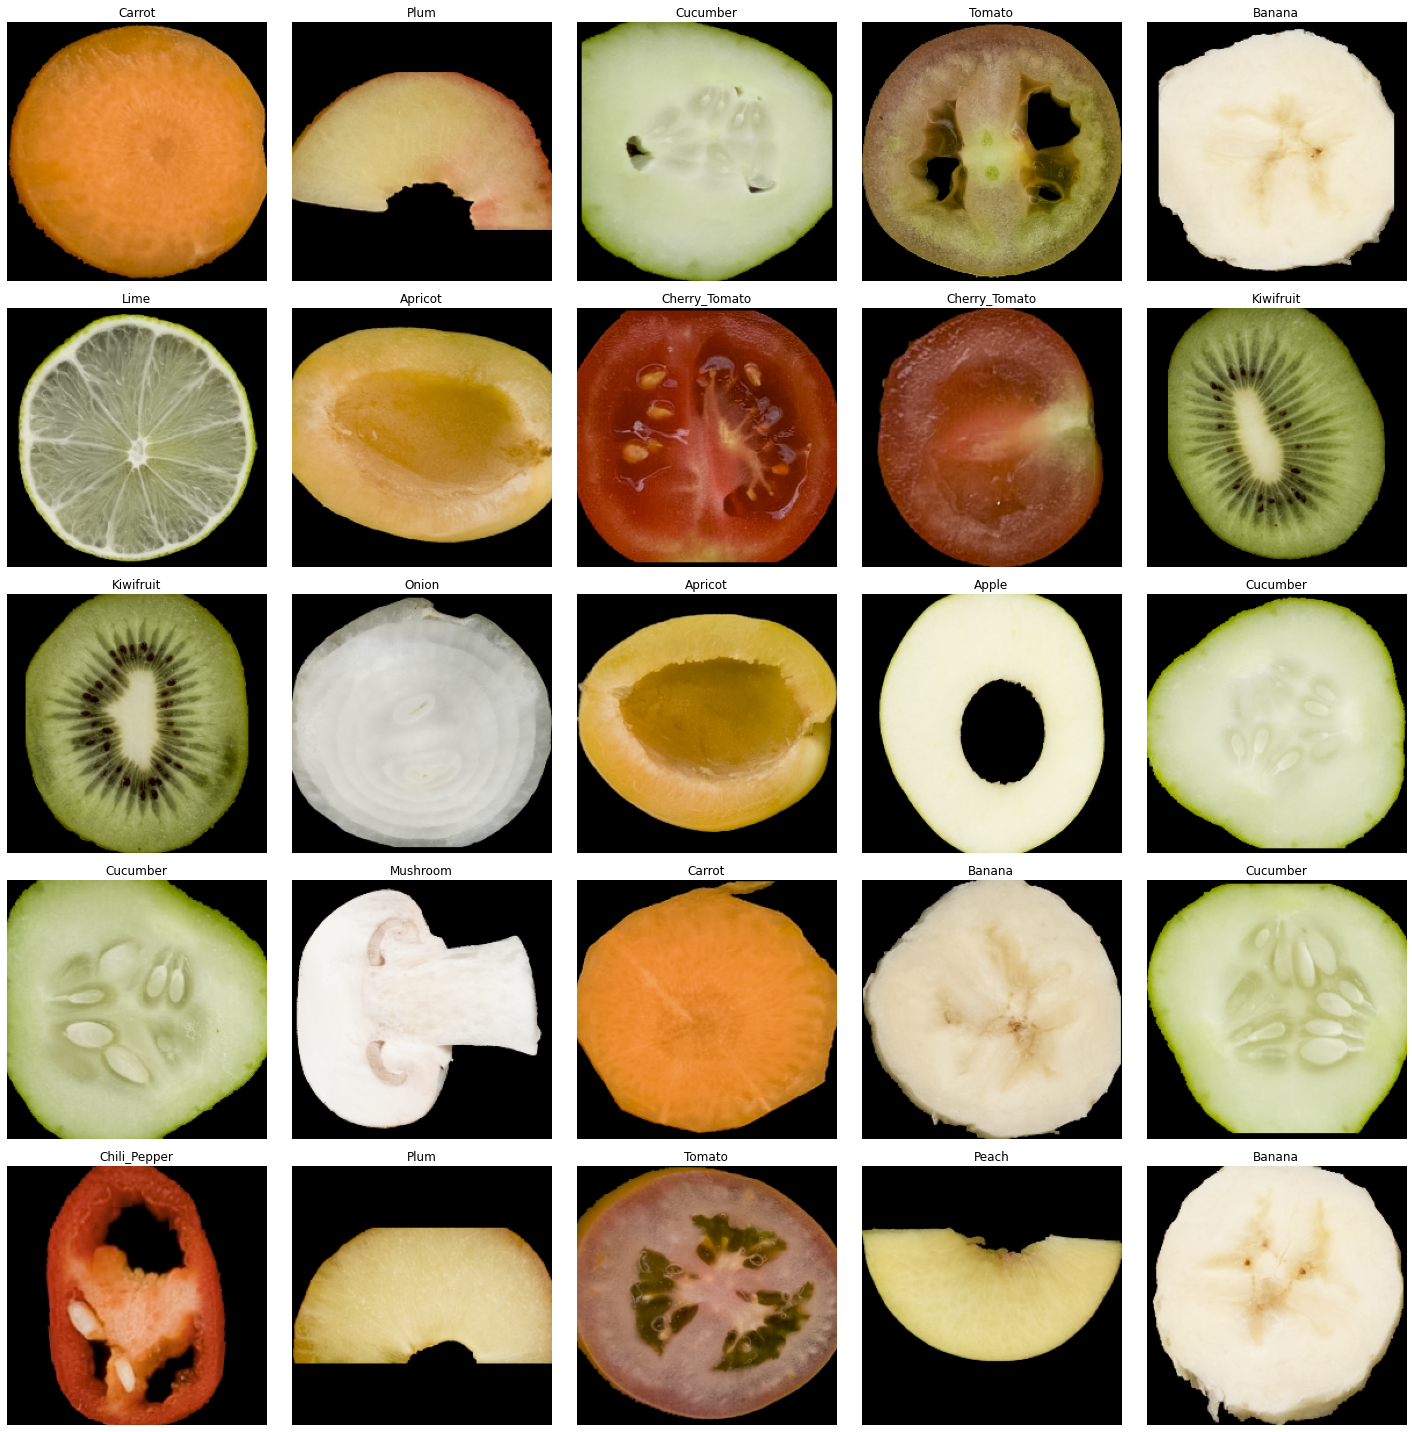

In [ ]:
data.show_batch()

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/simone/.cache/torch/checkpoints/resnet18-5c106cde.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


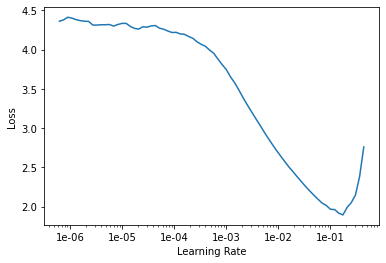

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 1e-2)

In [ ]:
learn.fit_one_cycle(4, 1e-2)

In [ ]:
learn.fit_one_cycle(1, 1e-3)

In [ ]:
learn.fit_one_cycle(1, 1e-3)

In [ ]:
learn.fit_one_cycle(1, 1e-3)

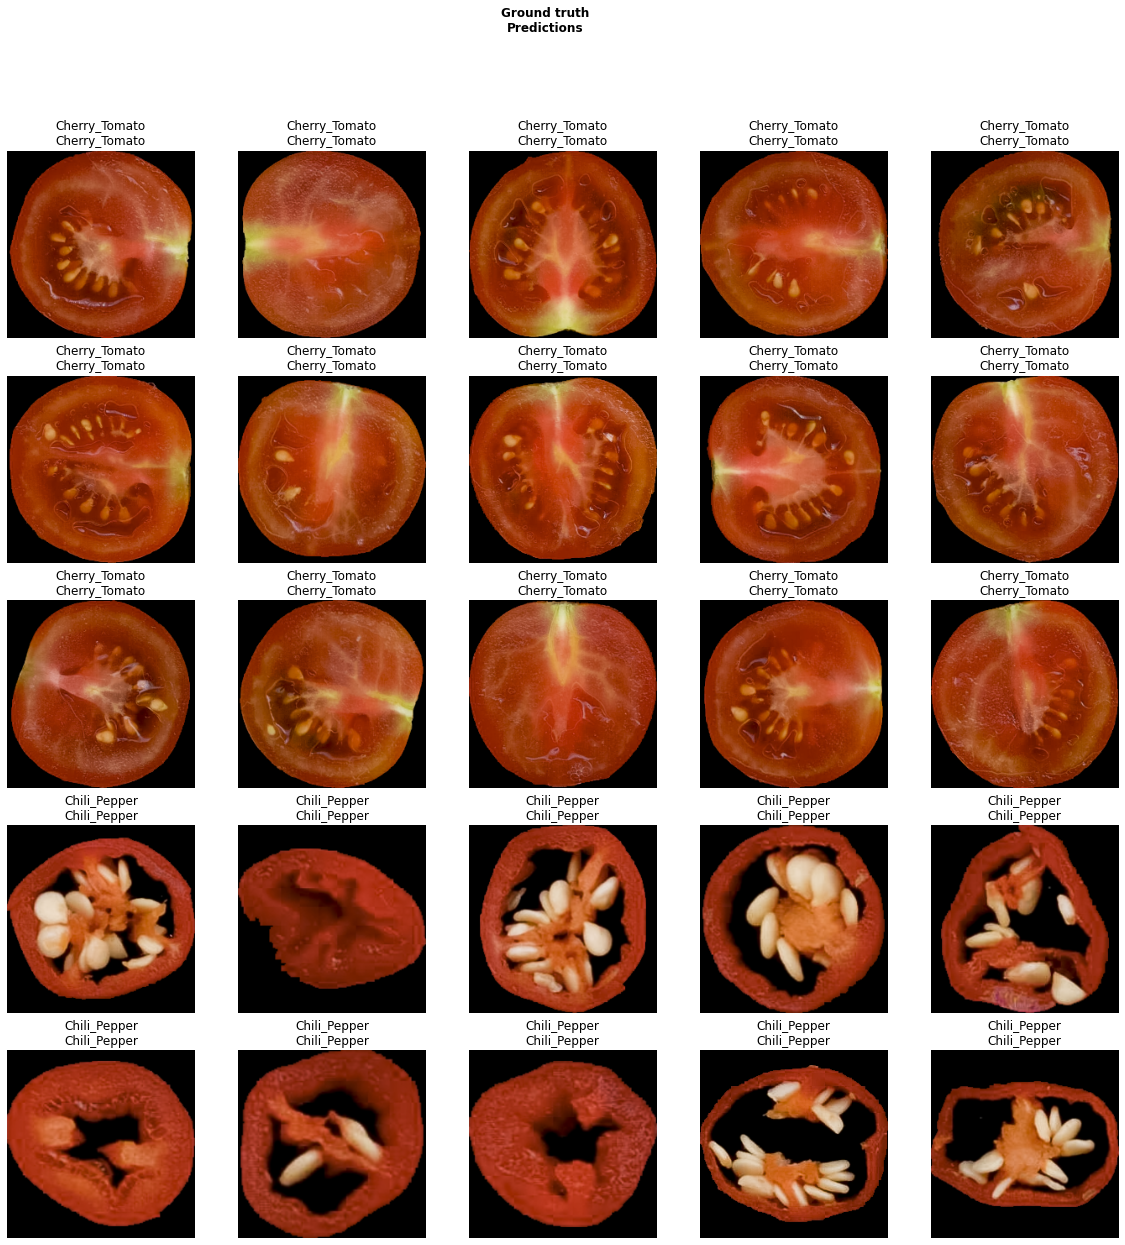

In [ ]:
learn.show_results()

In [ ]:
learn.export("models/Classification_resnet18_10_sept_2020.pkl")

In [ ]:
learn.predict(open_image("dataset_classification/train/Apricot/Apricot_0.png"))

(Category tensor(1),
 tensor(1),
 tensor([2.0863e-06, 9.9978e-01, 1.0954e-07, 1.8306e-05, 1.9337e-04, 5.5825e-08,
         4.7311e-09, 2.8877e-08, 4.3209e-06, 1.1469e-08, 9.6339e-08, 2.6675e-07,
         6.6181e-07, 1.2291e-07, 7.0517e-08, 2.0482e-07, 2.7318e-07]))

In [ ]:
intrp = learn.interpret()

In [ ]:
intrp.plot_top_losses(9)

In [ ]:
intrp.plot_confusion_matrix()

In [ ]:
data2 = data.add_test(ItemList.from_folder(path_img/"valid2"), LabelList)

In [ ]:
ItemList.from_folder(path_img/"valid2").split_none().label_from_folder()

LabelLists;

Train: LabelList (267 items)
x: ItemList
dataset_classification/valid2/Zucchini/Zucchini_60.png,dataset_classification/valid2/Zucchini/Zucchini_5.png,dataset_classification/valid2/Zucchini/Zucchini_6.png,dataset_classification/valid2/Zucchini/Zucchini_40.png,dataset_classification/valid2/Zucchini/Zucchini_63.png
y: CategoryList
Zucchini,Zucchini,Zucchini,Zucchini,Zucchini
Path: dataset_classification/valid2;

Valid: LabelList (0 items)
x: ItemList

y: CategoryList

Path: dataset_classification/valid2;

Test: None

In [ ]:
data.add_test??

Signature: data.add_test(items: Iterator, label: Any = None, tfms=None, tfm_y=None) -> None
Source:   
    def add_test(self, items:Iterator, label:Any=None, tfms=None, tfm_y=None)->None:
        "Add the `items` as a test set. Pass along `label` otherwise label them with `EmptyLabel`."
        self.label_list.add_test(items, label=label, tfms=tfms, tfm_y=tfm_y)
        vdl = self.valid_dl
        dl = DataLoader(self.label_list.test, vdl.batch_size, shuffle=False, drop_last=False, num_workers=vdl.num_workers)
        self.test_dl = DeviceDataLoader(dl, vdl.device, vdl.tfms, vdl.collate_fn)
File:      /opt/miniconda/envs/fastai/lib/python3.7/site-packages/fastai/basic_data.py
Type:      method


In [ ]:
valid2 = (ImageList.from_folder(path_img/"valid2", recurse=True)
           .split_none()
           .label_from_folder()
           .transform(size=img_size)
           .databunch(bs=bs)
           .normalize(imagenet_stats))

In [ ]:
learn.validate(valid2.train_dl)

[0.013407672, tensor(0.0039)]

In [ ]:
def get_preds_custom_ds(learn, dl):
    lf = learn.loss_func
    if not getattr(learn, 'opt', False): learn.create_opt(defaults.lr, learn.wd)
    callbacks = [cb(learn) for cb in learn.callback_fns + listify(defaults.extra_callback_fns)] + listify(learn.callbacks)
    return get_preds(learn.model, dl, cb_handler=CallbackHandler(callbacks), loss_func=lf)

In [ ]:
def class_intrp_custom_data(learn, data):
    intrp = ClassificationInterpretation(learn, *custom_get_preds(learn, data.train_dl))
    intrp.ds = data.train_ds
    return intrp

In [ ]:
class ImprClassIntrp(ClassificationInterpretation):
    @classmethod
    def from_custom_data(cls, learn, data):
        """can use a dataset different from the learner one, warning is uses always the training ds"""
        intrp = cls(learn, *custom_get_preds(learn, data.train_dl))
        data.train_ds.classes = learn.data.classes
        intrp.ds = data.train_ds
        return intrp
    def error_rate(self):
        return 1 - (self.y_true == self.pred_class).float().mean()
    def plot_top_losses(self, k=10, largest=True, figsize=(12,12), show_text:bool=True, return_fig:bool=None)->Optional[plt.Figure]:
        "Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class."
        tl_val,tl_idx = self.top_losses(k, largest)
        classes = self.data.classes
        cols = math.ceil(math.sqrt(k))
        rows = math.ceil(k/cols)
        fig,axes = plt.subplots(rows, cols, figsize=figsize)
        if show_text: fig.suptitle('Prediction/Actual/Loss/Probability', weight='bold', size=14)
        for i,idx in enumerate(tl_idx):
            im,cl = self.ds[idx]
            real_class = self.y_true[idx]
            pred_class = self.pred_class[idx]
            title = f'{classes[pred_class]}/{cl} / {self.losses[idx]:.2f} / {self.preds[idx][int(cl)]:.2f}' if show_text else None
            im.show(ax=axes.flat[i], title=title)
        if ifnone(return_fig, defaults.return_fig): return fig

In [ ]:
def mycrazy_intepretation(learn, data):
    y_true = torch.empty(len(data.train_ds), dtype=torch.int64)
    preds = torch.empty((len(data.train_ds), data.c))
    losses = torch.empty(len(data.train_ds))
    for i, (img, real) in zip(progress_bar(range(len(data.train_ds))), data.train_ds):
        pred = learn.predict(img)
        if pred[0] != real: img.show(title=f"{pred[0]} / {real}")
        y_true[i] = learn.data.c2i
        preds[i] = pred[2]
#         losses[i] = pred[2]
    return y_true, preds


In [ ]:
valid2.train_ds[100][1]

Category Peach

In [ ]:
y_true, preds = mycrazy_intepretation(learn, valid2)

KeyError: 16

In [ ]:
y_true == preds.argmax()

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [ ]:
learn.predict??

Signature:
learn.predict(
    item: fastai.core.ItemBase,
    return_x: bool = False,
    batch_first: bool = True,
    with_dropout: bool = False,
    **kwargs,
)
Source:   
    def predict(self, item:ItemBase, return_x:bool=False, batch_first:bool=True, with_dropout:bool=False, **kwargs):
        "Return predicted class, label and probabilities for `item`."
        batch = self.data.one_item(item)
        res = self.pred_batch(batch=batch, with_dropout=with_dropout)
        raw_pred,x = grab_idx(res,0,batch_first=batch_first),batch[0]
        norm = getattr(self.data,'norm',False)
        if norm:
            x = self.data.denorm(x)
            if norm.keywords.get('do_y',False): raw_pred = self.data.denorm(raw_pred)
        ds = self.data.single_ds
        pred = ds.y.analyze_pred(raw_pred, **kwargs)
        x = ds.x.reconstruct(grab_idx(x, 0))
        y = ds.y.reconstruct(pred, x) if has_arg(ds.y.reconstruct, 'x') else ds.y.reconstruct(pred)
        return (x, y, pred, raw_pred) if

In [ ]:
get_preds?

Signature:
get_preds(
    model: torch.nn.modules.module.Module,
    dl: torch.utils.data.dataloader.DataLoader,
    pbar: Union[fastprogress.fastprogress.MasterBar, fastprogress.fastprogress.ProgressBar, NoneType] = None,
    cb_handler: Union[fastai.callback.CallbackHandler, NoneType] = None,
    activ: torch.nn.modules.module.Module = None,
    loss_func: Union[Callable[[torch.Tensor, torch.Tensor], OneEltTensor], NoneType] = None,
    n_batch: Union[int, NoneType] = None,
) -> List[torch.Tensor]
Docstring: Tuple of predictions and targets, and optional losses (if `loss_func`) using `dl`, max batches `n_batch`.
File:      /opt/miniconda/envs/fastai/lib/python3.7/site-packages/fastai/basic_train.py
Type:      function


In [ ]:
get_preds_custom_ds(learn, valid2.train_dl)[1].dtype

torch.int64

In [ ]:
intrp2.top_losses().indices

tensor([ 59, 228,   0, 150, 155,  75, 148, 211,   6,  33, 106,  85, 102,  10,
        186, 169,  73,  11, 153, 202,  19, 244, 176, 120, 197, 209, 168,  16,
        181, 216, 252, 217, 144, 111,  36, 239, 208, 235, 219, 137,  94,  46,
         66,  55,  99, 114, 213, 192, 204,  95,  44, 104,  58, 109,  62, 115,
        139, 221,  97, 103,  61, 145,  96, 123,  72, 143, 230,  92, 185,  22,
        116,  76, 203,  50,  89,  41,  67, 135, 194,  81,  91,  45, 184,  79,
         49, 117, 132,  68,  86, 226, 248,  32, 140, 188,  14, 240, 173,  51,
        187, 165,  78, 178,  53, 152, 108, 147, 212, 232, 156,  70, 241, 171,
        215, 160,  39, 138, 134, 210, 183, 193, 133, 237,  21, 113, 218, 182,
        236, 131, 112, 105, 245, 196, 124,  80, 223,  54, 222,  34,  65,   2,
        126, 179,  18, 122,  57, 214, 159, 149,  35,  29, 100, 205,  26, 154,
         28, 189, 247,  60, 249,  69, 227,  48,  15, 172,  88,   3, 141, 110,
         27,  13,  31,  20, 162,  63, 170, 175, 190, 238, 130, 1

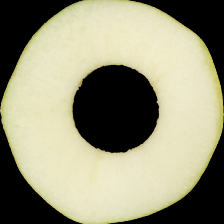

In [ ]:
intrp2.ds[50][0]

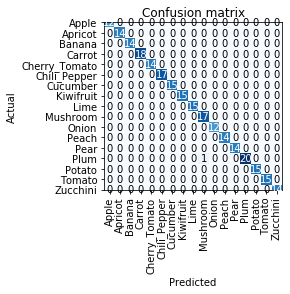

In [ ]:
intrp2.plot_confusion_matrix()

In [ ]:
int(intrp2.ds[50][1])

0

In [ ]:
intrp2.y_true[50]

tensor(9)

In [ ]:
intrp2.data.classes

['Apple',
 'Apricot',
 'Banana',
 'Carrot',
 'Cherry_Tomato',
 'Chili_Pepper',
 'Cucumber',
 'Kiwifruit',
 'Lime',
 'Mushroom',
 'Onion',
 'Peach',
 'Pear',
 'Plum',
 'Potato',
 'Tomato',
 'Zucchini']

In [ ]:
valid2.c2i

{'Apple': 0,
 'Apricot': 1,
 'Banana': 2,
 'Carrot': 3,
 'Cherry_Tomato': 4,
 'Chili_Pepper': 5,
 'Cucumber': 6,
 'Kiwifruit': 7,
 'Lime': 8,
 'Mushroom': 9,
 'Onion': 10,
 'Peach': 11,
 'Pear': 12,
 'Plum': 13,
 'Potato': 14,
 'Tomato': 15,
 'Zucchini': 16}

In [ ]:
intrp2.confusion_matrix??

Signature: intrp2.confusion_matrix(slice_size: int = 1)
Source:   
    def confusion_matrix(self, slice_size:int=1):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        else:
            cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)
            for i in range(0, self.y_true.shape[0], slice_size):
                cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            & (self.y_true[i:i+slice_size]==x[:,None,None])).sum(2)
                torch.add(cm, cm_slice, out=cm)
        return to_np(cm)
File:      /opt/miniconda/envs/fastai/lib/python3.7/site-packages/fastai/train.py
Type:      method


In [ ]:
intrp2 = ImprClassIntrp.from_custom_data(learn, valid2)

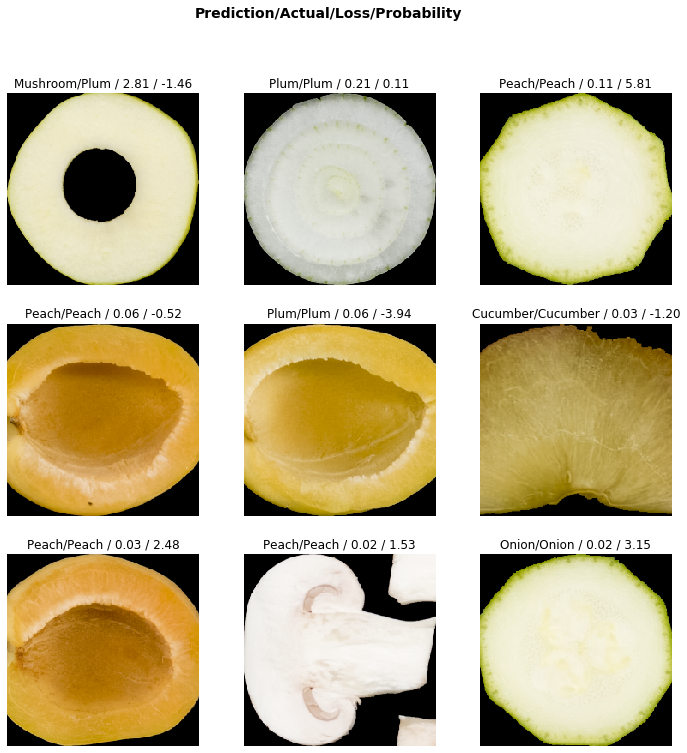

In [ ]:
intrp2.plot_top_losses(9)

In [ ]:
intrp2.y_true

tensor([16,  9, 13,  1, 14,  6, 15,  1,  8, 12, 11,  6, 15,  1, 13,  4,  9, 11,
         9,  1,  4, 11, 11,  1, 10, 16, 12, 15,  9,  4,  2,  8,  7, 10,  5,  2,
        10,  1,  3,  4, 14, 16, 13, 15,  3, 16,  0,  7,  0, 10, 15,  3, 13, 14,
        15,  5,  7,  6,  3, 13, 13,  5,  7, 15,  7, 12,  4,  3,  7,  7,  5,  9,
         1,  9, 15,  1,  0,  8,  7, 13,  3, 11, 15,  9,  2, 10, 14,  4, 10,  3,
        12,  4, 13,  9, 13,  3,  1, 10, 15,  8,  0,  2,  3, 16, 12,  7, 11, 16,
         3,  1,  6,  2,  0,  2,  6,  6,  3, 15,  7, 12,  8, 16, 10, 12,  6, 16,
        10,  2,  4, 14, 13,  5,  9, 10,  5,  4, 11,  3,  8,  0,  9,  4, 13,  6,
        11,  6,  2,  3, 14, 13, 14,  8,  0,  0,  9, 10, 12, 13,  6, 11, 11, 14,
         0,  9,  7, 11,  8, 12,  4,  7,  3,  7,  0,  3, 14,  8,  1, 16,  5,  0,
         4,  7, 13,  8,  5,  9,  2, 16,  0,  5,  6,  9,  0,  9, 13,  2, 10,  2,
        11,  1, 12, 12, 14,  8, 13,  8,  5, 16, 15,  1, 12,  0,  7, 14,  2,  5,
        11, 13,  4, 11, 14, 12,  5,  2, 

In [ ]:
intrp2.pred_class

tensor([16,  9, 13,  1, 14,  6, 15,  1,  8, 12, 11,  6, 15,  1, 13,  4,  9, 11,
         9,  1,  4, 11, 11,  1, 10, 16, 12, 15,  9,  4,  2,  8,  7, 10,  5,  2,
        10,  1,  3,  4, 14, 16, 13, 15,  3, 16,  0,  7,  0, 10, 15,  3, 13, 14,
        15,  5,  7,  6,  3, 13, 13,  5,  7, 15,  7, 12,  4,  3,  7,  7,  5,  9,
         1,  9, 15,  1,  0,  8,  7, 13,  3, 11, 15,  9,  2, 10, 14,  4, 10,  3,
        12,  4, 13,  9, 13,  3,  1, 10, 15,  8,  0,  2,  3, 16, 12,  7, 11, 16,
         3,  1,  6,  2,  0,  2,  6,  6,  3, 15,  7, 12,  8, 16, 10, 12,  6, 16,
        10,  2,  4, 14, 13,  5,  9, 10,  5,  4, 11,  3,  8,  0,  9,  4,  9,  6,
        11,  6,  2,  3, 14, 13, 14,  8,  0,  0,  9, 10, 12, 13,  6, 11, 11, 14,
         0,  9,  7, 11,  8, 12,  4,  7,  3,  7,  0,  3, 14,  8,  1, 16,  5,  0,
         4,  7, 13,  8,  5,  9,  2, 16,  0,  5,  6,  9,  0,  9, 13,  2, 10,  2,
        11,  1, 12, 12, 14,  8, 13,  8,  5, 16, 15,  1, 12,  0,  7, 14,  2,  5,
        11, 13,  4, 11, 14, 12,  5,  2, 

In [ ]:
intrp2.data.classes

['Apple',
 'Apricot',
 'Banana',
 'Carrot',
 'Cherry_Tomato',
 'Chili_Pepper',
 'Cucumber',
 'Kiwifruit',
 'Lime',
 'Mushroom',
 'Onion',
 'Peach',
 'Pear',
 'Plum',
 'Potato',
 'Tomato',
 'Zucchini']

In [ ]:
intrp2.error_rate()

tensor(0.0039)

In [ ]:
intrp2.ds.y.reconstruct??

Signature: intrp2.ds.y.reconstruct(t)
Docstring: Reconstruct one of the underlying item for its data `t`.
Source:   
    def reconstruct(self, t):
        return Category(t, self.classes[t])
File:      /opt/miniconda/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py
Type:      method


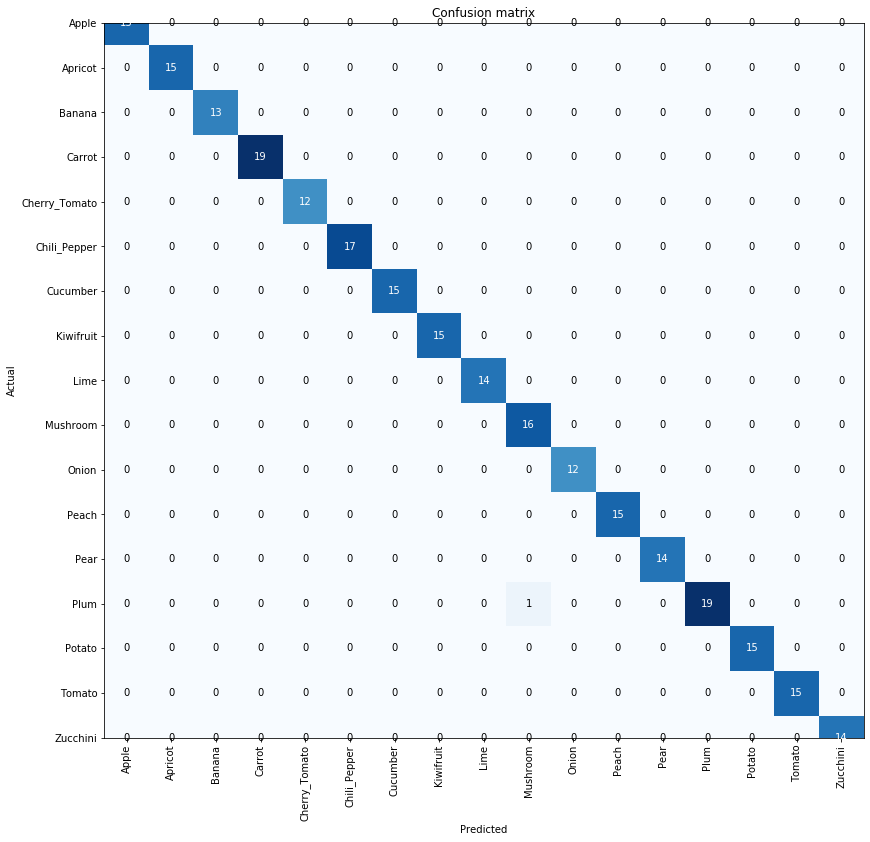

In [ ]:
intrp2.plot_confusion_matrix(figsize=(12,12))

In [ ]:
intrp2.pred_class

tensor([13, 13, 16,  3, 12,  7, 13,  5,  0,  2,  6,  9,  1, 16, 12,  2,  5,  2,
         4, 15,  5,  3,  6,  2,  7, 16,  1,  4,  2, 15,  9,  9,  8, 13,  7,  5,
        14, 10, 12, 13,  9,  8, 12, 14,  7, 10,  2,  3,  4,  6, 10, 11, 14,  6,
         5,  8, 11, 11, 14, 16, 14, 12,  1,  6, 12,  7,  6,  7,  3,  4,  4,  0,
         2, 16,  3, 15, 16,  1,  8,  5,  9,  0,  0,  7,  1,  8, 16,  0,  6,  2,
        13, 11,  0,  6, 16,  9, 12, 13, 15, 15,  3, 16,  2,  7,  9,  7, 11, 14,
        14, 12,  5, 11, 14,  0, 12,  3, 10, 13, 13, 10,  1, 10, 14,  1,  1,  1,
         9, 11,  9, 14, 13,  8, 13, 15, 10,  2,  6,  4,  6, 13,  8, 14, 10,  1,
        15,  4,  9,  7, 12, 11, 16,  2,  6, 11,  3, 13,  1, 11,  2, 14,  1, 10,
         0,  3,  0,  9, 14, 15, 13,  5,  9, 11,  9,  2,  3, 16, 15, 13,  4,  5,
         5, 10, 12, 15, 14,  5,  7, 10, 11, 16, 13,  5, 11,  0,  6,  8, 13,  9,
         4,  4, 11,  3,  6,  7, 16,  8,  9,  3, 14,  0,  9,  8, 12,  2,  2,  5,
        16,  5, 11,  8,  9,  3, 13,  3, 

In [ ]:
accuracy??

Signature: accuracy(input: torch.Tensor, targs: torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f32ac9039e0>
Source:   
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()
File:      /opt/miniconda/envs/fastai/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


In [ ]:
error_rate??

Signature: error_rate(input: torch.Tensor, targs: torch.Tensor) -> <function NewType.<locals>.new_type at 0x7f32ac9039e0>
Source:   
def error_rate(input:Tensor, targs:Tensor)->Rank0Tensor:
    "1 - `accuracy`"
    return 1 - accuracy(input, targs)
File:      /opt/miniconda/envs/fastai/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


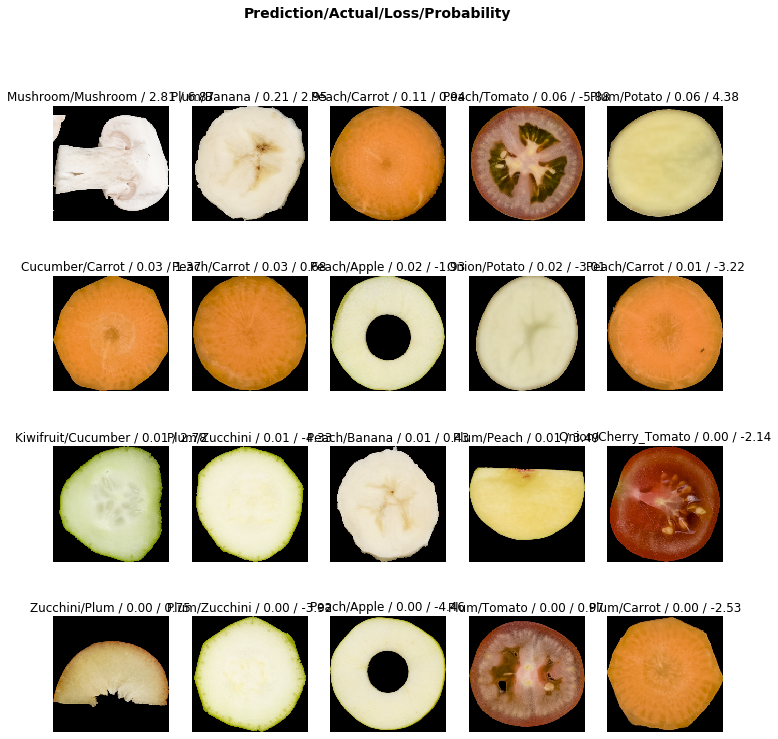

In [ ]:
intrp2.plot_top_losses(20)

In [ ]:
intrp = ClassificationInterpretation(learn, *custom_get_preds(learn, valid2.train_dl))
intrp.ds = valid2.train_ds

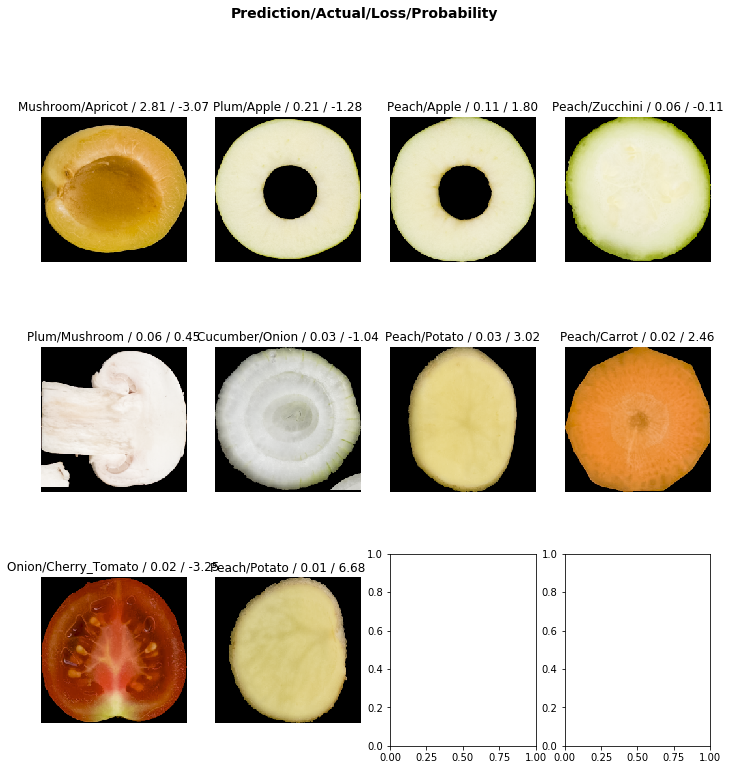

In [ ]:
intrp.plot_top_losses(10)

In [ ]:
custom_get_preds(learn, valid2.train_dl)

[tensor([[ 1.9666,  1.4225, -0.9778,  ..., -2.5463, -1.6259, 18.5390],
         [ 0.0369, 17.9765, -0.3006,  ..., -3.1278, -0.2134,  2.4247],
         [ 2.7473,  0.3643, -4.0764,  ..., -3.0779,  3.2283,  3.8795],
         ...,
         [-1.2752,  1.4641,  2.9518,  ...,  1.6116, -2.7463, -2.0527],
         [-0.8086,  3.6565, -2.8109,  ..., -4.9370, -0.4252, -3.3725],
         [ 1.9850,  2.1575, -3.9095,  ...,  5.9239, -0.7623, -1.0076]]),
 tensor([16,  1, 12, 14, 13, 14,  0,  6,  6,  3,  3, 15,  5,  7,  3,  9,  7,  0,
          5,  7, 14, 11,  5, 16, 11,  3, 10,  9, 14, 13, 14,  7,  9, 13, 12, 12,
          9,  2, 11,  6,  7, 15, 13, 10,  2,  5,  8, 12,  5, 10, 15, 15,  4,  8,
          4, 15,  3,  1,  5,  0, 16,  6,  0, 15, 11,  5,  1, 15,  4,  1,  5,  1,
          3,  3,  3,  9, 14, 10,  6,  4,  9,  5, 10, 12,  7,  6,  0,  0,  3,  2,
          8,  0,  7, 16, 15,  0,  6,  4, 13,  8,  4, 15,  9,  7,  9, 11, 14, 13,
         16,  2,  2,  3,  4, 16,  4,  2,  6,  6,  7,  3, 16,  4,  1, 13,

In [ ]:
def intrp_from_dl(learn, dl):
    n_items = len(dl)
    preds = torch.empty((n_items, dl.c))
    y_true = torch.empty((n_items, dl.c))
    losses = torch.empty((n_items))
    for i, items in enumerate(dl):
        for item in items:
            _, loss, pred = learn.predict(dl.reconstruct(item[0].cpu()))
            preds[i] = pred
            y_true = item[1]
            losses[i] = loss
    return ClassficationInterpretation(learn, preds, y_true, losses)

In [ ]:
def intrp_from_ds(learn, ds):
    n_items = len(ds)
    preds = torch.empty((n_items, ds.c))
    y_true = torch.empty((n_items, ds.c))
    losses = torch.empty((n_items))
    for i, item in enumerate(ds):
        _, loss, pred = learn.predict(item[0])
        preds[i] = pred
        y_true[i] = ds.y.c2i.get(str(item[1]))
        losses[i] = loss
    return ( preds, y_true, losses)

In [ ]:
intrp_from_ds(learn, valid2.train_ds)

(tensor([[2.8782e-08, 2.6430e-06, 1.2659e-07,  ..., 8.3649e-10, 2.4667e-08,
          1.0000e+00],
         [7.6909e-07, 1.2136e-06, 2.6948e-07,  ..., 1.5193e-07, 4.0422e-08,
          1.0000e+00],
         [2.3611e-08, 2.7362e-09, 1.1594e-09,  ..., 1.7272e-08, 8.5232e-10,
          1.0000e+00],
         ...,
         [4.7414e-11, 7.6306e-15, 2.8560e-11,  ..., 2.2471e-10, 1.2944e-13,
          6.8267e-12],
         [1.1341e-07, 3.7944e-08, 1.3894e-06,  ..., 1.3121e-08, 8.8330e-08,
          8.4970e-07],
         [1.8576e-07, 6.0469e-09, 3.6876e-07,  ..., 1.0150e-07, 1.0667e-07,
          1.2390e-07]]), tensor([[16., 16., 16.,  ..., 16., 16., 16.],
         [16., 16., 16.,  ..., 16., 16., 16.],
         [16., 16., 16.,  ..., 16., 16., 16.],
         ...,
         [ 5.,  5.,  5.,  ...,  5.,  5.,  5.],
         [ 5.,  5.,  5.,  ...,  5.,  5.,  5.],
         [ 5.,  5.,  5.,  ...,  5.,  5.,  5.]]), tensor([16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
         16.,  

In [ ]:
valid2.train_ds.y.process_one??

Signature:
valid2.train_ds.y.process_one(
    item: fastai.core.ItemBase,
    processor: Union[fastai.data_block.PreProcessor, Collection[fastai.data_block.PreProcessor]] = None,
)
Source:   
    def process_one(self, item:ItemBase, processor:PreProcessors=None):
        "Apply `processor` or `self.processor` to `item`."
        if processor is not None: self.processor = processor
        self.processor = listify(self.processor)
        for p in self.processor: item = p.process_one(item)
        return item
File:      /opt/miniconda/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py
Type:      method


In [ ]:
dir(valid2.train_ds.y)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bunch',
 '_get_by_folder',
 '_label_cls',
 '_label_from_list',
 '_label_list',
 '_processor',
 '_relative_item_path',
 '_relative_item_paths',
 '_split',
 '_square_show',
 '_square_show_res',
 'add',
 'analyze_pred',
 'c',
 'c2i',
 'classes',
 'copy_new',
 'databunch',
 'filter_by_folder',
 'filter_by_func',
 'filter_by_rand',
 'filter_missing_y',
 'from_csv',
 'from_df',
 'from_folder',
 'get',
 'get_label_cls',
 'ignore_empty',
 'inner_df',
 'items',
 'label_cls',
 'label_const',
 'label_empty',
 'label_from_df',
 'label_from_folder',
 'label_from_func',
 'label_from_re',
 'loss_func',
 'ne

In [ ]:
valid2.train_ds.

AttributeError: 'CategoryList' object has no attribute 'predict'

In [ ]:
learn.get_preds??

Signature:
learn.get_preds(
    ds_type: fastai.basic_data.DatasetType = <DatasetType.Valid: 2>,
    activ: torch.nn.modules.module.Module = None,
    with_loss: bool = False,
    n_batch: Union[int, NoneType] = None,
    pbar: Union[fastprogress.fastprogress.MasterBar, fastprogress.fastprogress.ProgressBar, NoneType] = None,
) -> List[torch.Tensor]
Source:   
    def get_preds(self, ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None,
                  with_loss:bool=False, n_batch:Optional[int]=None, pbar:Optional[PBar]=None) -> List[Tensor]:
        "Return predictions and targets on `ds_type` dataset."
        lf = self.loss_func if with_loss else None
        activ = ifnone(activ, _loss_func2activ(self.loss_func))
        if not getattr(self, 'opt', False): self.create_opt(defaults.lr, self.wd)
        callbacks = [cb(self) for cb in self.callback_fns + listify(defaults.extra_callback_fns)] + listify(self.callbacks)
        return get_preds(self.model, self.dl(ds_type), cb

In [ ]:
preds = custom_get_preds(learn, valid2.train_dl)

In [ ]:
intrp_valid1 = ClassificationInterpretation(learn, *preds)

In [ ]:
learn.predict?

Signature:
learn.predict(
    item: fastai.core.ItemBase,
    return_x: bool = False,
    batch_first: bool = True,
    with_dropout: bool = False,
    **kwargs,
)
Docstring: Return predicted class, label and probabilities for `item`.
File:      /opt/miniconda/envs/fastai/lib/python3.7/site-packages/fastai/basic_train.py
Type:      method


ValueError: not enough values to unpack (expected 3, got 0)

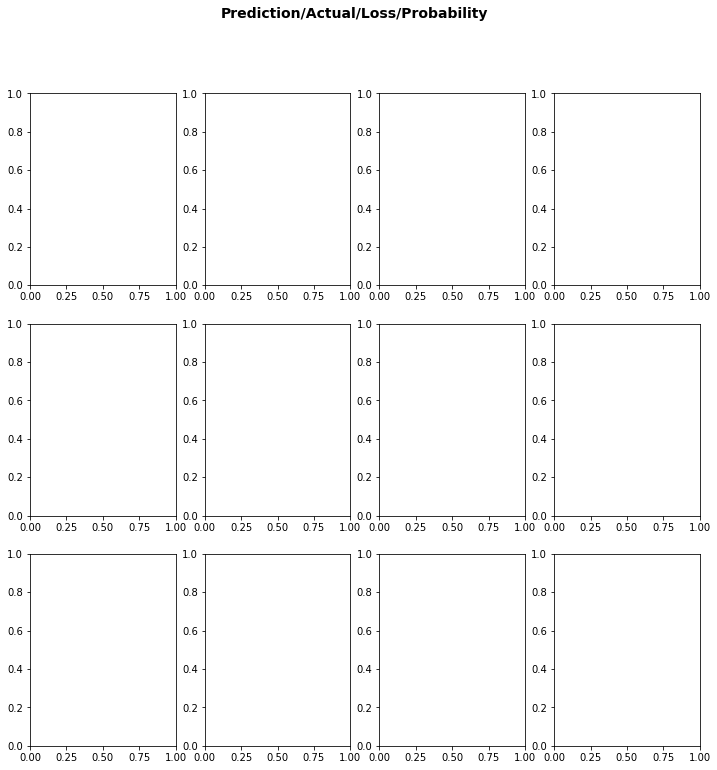

In [ ]:
intrp_valid1.plot_top_losses(10)

In [ ]:
Image(list(valid1.train_dl)[0][0][0])

In [ ]:
valid1.train_dl.c

In [ ]:
for b in valid1.train_dl:
    res = learn.pred_batch(batch=b)

In [ ]:
list(valid1.train_dl)

In [ ]:
res[0]

In [ ]:
get_preds_ds(learn, valid1.train_dl)

In [ ]:
learn.validate(dl=valid1.train_dl, metrics=[error_rate])

In [ ]:
learn.predict(intrp.ds[10][0])

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/fruit-detection/dataset_classification/Kiwifruit/Kiwifruit1_3.png'

In [ ]:
learn.predict(intrp.ds[200][0])

In [ ]:
data = (ImageList.from_folder(path_img, recurse=True)
                       .split_by_rand_pct()
                       .label_from_folder()
                       .transform(tfms, size=img_size, resize_method=ResizeMethod.PAD, padding_mode='zeros')
                       .databunch(bs=bs)
                       .normalize(imagenet_stats))

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(3, 1e-2)

## Training from scratch without imagenet

In [ ]:
data_scratch = (ImageList.from_folder(path_img, recurse=True)
                       .split_by_rand_pct()
                       .label_from_folder()
                       .transform(tfms, size=img_size, resize_method=ResizeMethod.PAD, padding_mode='zeros')
                       .databunch(bs=bs)
                       .normalize(imagenet_stats))

In [ ]:
learn_s = cnn_learner(data_scratch, models.resnet18, pretrained=False, metrics=error_rate)

In [ ]:
learn_scratch.lr_find()
learn_scratch.recorder.plot()

In [ ]:
learn_s.fit_one_cycle(5, 5e-3)

In [ ]:
learn_s.fit_one_cycle(5, 1e-3)

In [ ]:
data_scratch

In [ ]:
intrp_s = learn_s.interpret()

In [ ]:
intrp_s.plot_top_losses(9)

# Test different random splits

In [ ]:
datas = [(ImageList.from_folder(path_img, recurse=True)
                       .split_by_rand_pct(split)
                       .label_from_folder()
                       .transform(tfms, size=img_size, resize_method=ResizeMethod.PAD, padding_mode='zeros')
                       .databunch(bs=bs)
                       .normalize(imagenet_stats)) for split in list(np.arange(.2, 1, .1)) * 4]

In [ ]:
def test_traing(data, epochs=5, lr=1e-2):
    learn = cnn_learner(data, models.resnet18, metrics=error_rate)
    print("%split: ", len(data.valid_ds) /(len(data.valid_ds)+ len(data.train_ds)))
    learn.fit_one_cycle(epochs, lr)
    metrics = np.array(learn.recorder.metrics)
    learn.destroy()
    return metrics

In [ ]:
results = [test_traing(data, lr=5e-3) for data in datas]

In [ ]:
results = pd.DataFrame(np.concatenate([np.tile(np.arange(.2, 1, .1), 4).reshape((-1, 1)),np.array(results).squeeze()], axis=1))

In [ ]:
results.sort_values(1)

In [ ]:
np.array(results).shape

In [ ]:
np.arange(.2, 1, .1)[None].shape

In [ ]:
list(range(2, 9, 1))

In [ ]:
len(data.valid_ds)